# Simulate gamma ray sources in galaxy

## Imports and definitions

In [2]:
#Imports
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import poisson, laplace, lognorm
from astropy.io import fits
from astropy.table import Table,join
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import catalog_spect
from scipy.optimize import curve_fit
import astropy.coordinates as coord
from astropy import units
from matplotlib import gridspec
from matplotlib import rc
import matplotlib.ticker
import makemap
rc('font',**{'family':'serif'})
rc('text',usetex=True)

##colors
c6 = '#e41a1c'
c2 = '#377eb8'
c3 = '#4daf4a'
c4 = '#984ea3'
c5 = '#ff7f00'
c1 = '#66c2a5'
c7 = '#a65628'
c8 = '#f781bf'
c9 = '#999999'
colors = [c1,c2,c3,c4,c5,c6,c7,c8,c9]

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 6)
#constants 
kpc = 3.08567758e21 #cm

##SNR distribution From Green 2015
alp_snr = 1.09
bet_snr = 3.98
H_snr = 0.083 #jian-wen xu et al 2004

Rsun = 8.3
hb = 10 #This is considered as high latitude

##This is for pulsars
model = 'C' #Set model to S or C
if model=='C':
    H=0.18
    alp=1.9
    bet = 5.0
if model=='S':
    H=0.33
    alp=0.2
    bet = 1.4
if model=='SNR':
    H = 0.083
    alp = alp_snr
    bet = bet_snr
#Trheshold of fermi, from 3fgl paper
fermi_thres = 5e-10

##Setting up some things for later
minflux,maxflux=-14,-5
bins = np.logspace(minflux,maxflux,25)
bins_mean = (bins[1:]+bins[:-1])/2.

#lb regions
lb = [(180,20),(180,5),(180,1),(20,20),(20,5),(20,1)]

##Set up bins for energy for fhl (10-1000GeV) and fgl (0.1-100GeV)
Efhl = np.logspace(1,3,100)#GeV
E3fgl_bins = np.logspace(-1,2,101)
E3fgl = (E3fgl_bins[1:]+E3fgl_bins[0:-1])/2.
E3fgl_dE = (E3fgl_bins[1:]-E3fgl_bins[0:-1])
mask_E3fgl = (E3fgl>=1)&(E3fgl<=100)
#bins in energy for our use (1-1000GeV)
Ebins = np.logspace(0,3,101)
E = (Ebins[1:]+Ebins[0:-1])/2.
dE = (Ebins[1:]-Ebins[0:-1])
mask_E3fhl = E>100
mask_E = (E>=1)&(E<=100)

###From tevcat 
Lmin_tev = 3.96e34
Lmax_tev = 1.79e38

## Function definitions

In [3]:
#Function definitions
from scipy.stats import expon
##Drawing random numbers
def rand_R(n,a,b,Rsun=Rsun):
    "Return random value of R, pdf is above, this is a gamma distribution"
    return np.random.gamma(a+1,1./b,n)*Rsun

def rand_R_norm(n,mu,sig):
    "return normal random"
    return np.random.normal(mu,sig,n)

def rand_R_SNI(n,a,Rsun=Rsun):
    return np.random.exponential(a,n)

def R_SNR_ferriere(R):
    sig1 = 4.8*np.exp(-(R-Rsun)/4.5)
    sig2 = 27*np.where(R < 3.7,3.55*np.exp(-((R-3.7)/2.1)**2),
                   np.exp(-(R**2-Rsun**2)/6.8**2))
    return sig1+sig2

###CDFs for R ferriere only
rspace = np.linspace(0,30,1000)
data_r = R_SNR_ferriere(rspace)
data_r = data_r/np.sum(data_r) #normalize
data_r_cdf = np.cumsum(data_r)#cdf

# def rand_R_SNR_ferriere(N):
#     R_smpl = np.zeros(N)
#     r = np.linspace(0,30,1000)
#     data_r = R_SNR_ferriere(r)
#     data_r = data_r/np.sum(data_r) #normalize
#     data_r_cdf = np.cumsum(data_r)#cdf
#     u = np.random.rand(N)
#     for i in range(N):
#         #Inverse transform sampling, numerical
#         xx= np.argmax(u[i]<=data_r_cdf)
#         R_smpl[i]=r[xx]
#     return R_smpl

def ITS(N,x,cdf):
    """Function to do inverse transform sampling 
    
    Input:
    N: int, number of desired random samples
    x: array, possible returned random samples
    cdf: cdf function
    
    """
    smpl = np.zeros(N)
    u = np.random.rand(N)
    for i in range(N):
        #Inverse transform sampling, numerical
        ix= np.argmax(u[i]<=cdf)
        smpl[i]=x[ix]
    return smpl

# atest=[(1.09,3.98),(0.2,1.4),(1.9,5.0)]
# labels = ['SNR Green','Lorimer S','Lorimer C', 'Ferriere SNRI+II']

# f,ax = plt.subplots(1,figsize=(7,5))
# for i,a in enumerate(atest):
#     ax.hist(rand_R(30000,a[0],a[1]),bins=np.linspace(0,25),label=labels[i],histtype='step',color=colors[i+3])

    
# ax.hist(ITS(30000,rspace,data_r_cdf),bins=np.linspace(0,25),label=labels[3],histtype='step',color=colors[i+4])
# ax.set_xlim([0,20])
# ax.set_xlabel(r'$R \ \mathrm{[kpc]}$',fontsize=16)
# ax.set_ylabel(r'Number of sources',fontsize=16)
# ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
# plt.legend(frameon=False,fontsize=16)
# #plt.savefig('R_hist.pdf')

# plt.close('all')


def rand_z(n,H=H):
    """Return random z from laplace distribution=exp(-abs(z))
    n = number of randoms"""
    return np.random.laplace(0,H,n)

def z_SNR_ferriere(z):
    "z in pc"
    R1 = 7.3*np.exp(-np.abs(z)/325.)
    R2 = 50 * (0.79*np.exp(-(z/212.)**2)+0.21*np.exp(-(z/636.)**2))
    return R1+R2


###CDFs for z ferriere only
zspace = np.linspace(-3000,3000,1000)
data_z = z_SNR_ferriere(zspace)
data_z = data_z/np.sum(data_z) #normalize
data_z_cdf = np.cumsum(data_z)#cdf

def rand_z_SNR_ferriere(N):
    z_smpl = np.zeros(N)

    u = np.random.rand(N)
    for i in range(N):
        #Inverse transform sampling, numerical
        xx= np.argmax(u[i]<=data_z_cdf)
        z_smpl[i]=z[xx]
    return z_smpl/1000. #kpc

def rand_L(u,a,Lmin,Lmax):
    """Random L generator. Uses inverse transform sampling.
        u is a uniform random number between 0-1, a is the index of the
        power law distributiond desired.
        L = CDF^-1(u)
    """
    if a==1:
        print "a==1, error" #does not work for this..
        return 0
    return (u*(Lmax**(1-a)-Lmin**(1-a))+Lmin**(1-a))**(1/(1-a))

# Ltest = [1.5,1.8,2.1]
# f,ax = plt.subplots(1,figsize=(7,5))
# for i,l in enumerate(Ltest):
#     ax.hist(rand_L(np.random.rand(30000),l,2e34,2e39),bins=np.logspace(34,39,25), color=colors[i],
#            label='index = %s'%l,histtype='step',log=True)
#     ax.set_xscale('log',nonposx='clip')
#     ax.set_xlabel(r'Luminosity $\rm{ph \ s^{-1}}$',fontsize=16)
#     ax.set_ylabel(r'Number of sources',fontsize=16)
#     ax.set_ylim([0.1,2e4])
#     ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
# plt.legend(frameon=False,fontsize=16)
# plt.savefig('lum_hist.pdf')

def norm_spec(spec,flux,dE,mask):
    """This function normalizes the spec(actually wrong_spec below) 
    to the integrated flux from 1-100GeV
    """
    wrong_spec = spec*flux
    norm = np.sum(wrong_spec[mask]*dE[mask])
    return wrong_spec*flux/norm

def read_catalog(fn,catalog='fgl',classes=['pwn','snr','spp']):
    """
    Reads the catalog, either 3FGL or 3FHL, and returns the average 
    spectrum of the desired sources.
    
    Still have to adjust so that it returns the right spectrum...
    
    Returns also the histogram counts vs flux
    """
    data = fits.getdata(fn)
    tb = Table(data)
    if catalog=='fgl':
        _E = E3fgl
        cls = np.asarray(tb['CLASS1'].tolist())
    else:
        _E = Efhl
        cls = np.asarray(tb['CLASS'].tolist())
    cls = np.char.lower(np.char.rstrip(cls,' '))
    mask = np.zeros_like(cls,dtype=bool)

    for m in classes:
        mask = (cls==m)|mask
    
    if catalog == 'fgl':
        flux = tb[mask]['Flux1000']
    if catalog == 'fhl':
        flux = tb[mask]['Flux']

    spec = catalog_spect.get_spec(fn) ###This function returns the spectra of the catalogue    
    spec = spec[mask]
    
    ave_spec = 10**np.average(np.log10(spec),axis=0)
    #ave_spec = np.average(spec,axis=0)
    #ave_spec = np.average(spec,axis=0)
    #plt.loglog(_E,_E**2*np.average(spec,axis=0),color='b',lw=5)
    
    hist_3fgl = np.histogram(flux,bins=bins)[0]
    total_flux = np.sum(flux)

    if catalog=='fgl':
        ind = np.mean(tb[mask]['Spectral_Index'])
    if catalog=='fhl':
        ind = np.mean(tb[mask]['PowerLaw_Index'])

    plotfunc = lambda E,a,b: b*(E)**-a

   # spec = plotfunc(E,ind,1)
   # spec = ave_spec
    #good_spec = norm_spec(spec,total_flux,dE,mask_E)
    #spec_normed = good_spec/np.max(good_spec)

    return hist_3fgl,ave_spec,spec#spec_normed,ind

## Read CTA DC data

In [4]:
import readXML

CTA_file = 'catalog_gps_20180124.xml'
CTA_file_lowTS = 'catalog_gps_20180124_lowTS.xml'

flux_CTA,spec_CTA,E_CTA = readXML.flux_spec(CTA_file) ##Flux from 300-1000 GeV ph s^-1 cm^-2

In [5]:

            
print np.max(flux_CTA)*4*np.pi*(2*kpc)**2
print np.min(flux_CTA)*4*np.pi*(1*kpc)**2


2.71375313961e+34
1.03308657981e+31


In [6]:
bins = np.logspace(-17,-10,30)
bins_mean = (bins[1:]+bins[:-1])/2.
hist_CTA = np.histogram(flux_CTA,bins=bins)[0]

spec_ave_CTA = np.average(spec_CTA,axis=0)

Ebins = np.logspace(2,5,51)
E = (Ebins[1:]+Ebins[0:-1])/2.
dE = (Ebins[1:]-Ebins[0:-1])
mask_E = (E>=300)&(E<=1000)
spec_ave_CTA = 1e-9*E**-2.2

## Load diffuse data

In [7]:
###Load diffuse flux from skyfact fit
###Here load the diffuse flux at different l,b. To plot some fractions later.

import open_dat
from scipy import optimize

def errfunc(theta,f,x,y,yerr):
    """leastsq function"""
    if isinstance(yerr,int):
        yerr = yerr
    else:
        yerr = yerr/(np.log10(10)*y)
    x = np.log10(x)
    y = np.log10(y)
    model = f(x,theta)
    return np.sum(((y-model)/yerr)**2)

fitf = lambda *args: errfunc(*args)

modelfunc = lambda x,p: p[0]-p[1]*x

model27 = lambda x,p: p[0]-2.7*x

p0 = [-7,2.7]

def fit_index(E,flux,error=1,model=modelfunc,p0=p0):
    #fit,cov = curve_fit(model,np.log10(E),np.log10(flux),sigma=error/(np.log10(10)*flux),p0=p0)
    res = optimize.minimize(fitf,p0,args=(model,E,
                                            flux,error))
    return res["x"],res["hess_inv"]
    #return fit,cov

def read_datfile(datFile):
    "Read dat file and return total gas spec (sum)"
    E_diff = datFile['emean']
    deltaE = datFile['delta_e']
    total_gas_spec = np.zeros_like(E_diff)
    total_gas_err = np.zeros_like(E_diff)
    mask_diff = E_diff > 1
    for d in datFile:
        if 'Gas' in d and not 'err' in d:
            total_gas_spec+=datFile[d]
            total_gas_err +=datFile[d+'_err']
    return total_gas_spec/deltaE,E_diff,total_gas_err/deltaE
    
spec_diff_lb = []
diff_index_lb = []
spec_27_l = []
spec_dat = []
plotfunc = lambda E,a,b: b*(E)**-a
fitfunc = lambda E,a,b: b-a*(E)

for ilb in lb:
    datfile = open_dat.open_dat('/home/mart/mp/git_mp/spec_ll_bb/r5_fulldisk_combine_l%s_b%s.dat'%ilb)
    spec,E_diff,error = read_datfile(datfile)
    spec_dat.append(spec)
    mask_E_diff = E_diff > 2
    E_diff2 = E_diff
    E_diff = E_diff[mask_E_diff]
    spec = spec[mask_E_diff]
    err = error[mask_E_diff]
    
    fit,cov = fit_index(E_diff,spec,err,model=modelfunc,p0=[-7,2.7])
    fit27,cov27 = fit_index(E_diff,spec,err,model=model27,p0=[-7])

    ####
    ####This matters a lot!
    diff_index = fit[1]

    fitted_spec = plotfunc(E,diff_index,10**fit[0]) ##If this is a softer spectra this matters a lot!

    spec_diff_lb.append(fitted_spec)



## Simulate sources

In [8]:
##This is the galaxy simulation
#Do the simulation of sources

def source_sim(a=1.8,N=30000,Lmin=2e34,Lmax=2e39,alpha=alp,beta=bet,H=H,
            SNR=False,PSR=False,f_t=5e-10,flux_cutoff=1e-20,spectrum=spec_ave_CTA,createmap=False):
    #np.random.seed(0)
    """Sample from above distribution N times: r,z,L and calculate flux as measured at earth.
    Returns histogram of sources, total flux from sources and average spec from sources and
    fraction of unresolved/diffuse.
    """
    
    N = int(N) #no samples just to be sure 
    x0,y0,z0 = Rsun,0,0 #Location of us
    ##
    ##Drawing random numbers here
    u2 = np.random.rand(N)# For L
    phi_smpl = np.random.rand(N)*2*np.pi #uniform distribution for phi
    L_smpl = rand_L(u2,a,Lmin,Lmax)#random L
    
    if model=='ferriere':
        R_smpl = ITS(N,rspace,data_r_cdf)
        z_smpl = ITS(N,zspace,data_z_cdf)/1000. #kpc
    else:
        z_smpl = rand_z(N,H)
        R_smpl = rand_R(N,alpha,beta)

    #distances from source to earth, calc flux
    x,y,z = R_smpl*np.cos(phi_smpl),R_smpl*np.sin(phi_smpl),z_smpl
    dist = np.sqrt(((x-x0))**2+((y-y0))**2+(z-z0)**2)
    distkpc = (dist*kpc)
    flux_data = L_smpl/(4*np.pi*distkpc**2)
    #print np.mean(dist)
    ##Calculate longitude and latitude
    l = np.arctan2((y0-y),(x0-x))
    b = np.arctan((z-z0)/np.sqrt((x-x0)**2+(y-y0)**2))
    l *= 180/np.pi
    b *= 180/np.pi
        
    #histogram for normalization
    hist = np.histogram(flux_data,bins=bins)[0]
    mask_flux = flux_data < f_t
    meandist = np.mean(dist[flux_data > 5e-9])
    maskb = np.abs(b) <= 20.25
    fluxb = flux_data[maskb]
    total_flux = np.sum(fluxb[fluxb <f_t])
    
    if createmap:
        mp = makemap.makemap(l[mask_flux],b[mask_flux],flux_data[mask_flux],0.5)
    else:
        mp = 0
       
    #Fluxes at different regions,lb
    spec_unres = []
    frac = []
    frac_tev = []
    for ilb,_lb in enumerate(lb):
        ll,bb = _lb
        mask_l = np.abs(l)<=ll
        mask_b = np.abs(b)<=bb
        total_flux_lb = flux_data[mask_l&mask_b]
        flux_unresolved = total_flux_lb[total_flux_lb<f_t]
        total_flux_unres = np.sum(flux_unresolved)
        spec_sim = norm_spec(spectrum,total_flux_unres,dE,mask_E)
        diffuse = spec_diff_lb[ilb]
        frac_TeV = total_flux_unres/np.sum((spec_diff_lb[ilb]*dE)[mask_E])
        frac_tev.append(frac_TeV)
        frac.append(spec_sim/diffuse)
        spec_unres.append(spec_sim)

    return hist,frac,mp,total_flux,frac_tev,flux_data#,flux_R_unres#,mp

In [38]:
#Runs simulation Nsmpl times with N=n.o. sources, normalize to 3fgl sources
##Get average and std from Nsmpl runs, plot histogram to compare with hist of 3fgl sources

def ave_samples(Nsmpl=10,Nsnr=10000,LF_i_snr=1.5,Lmin_snr=1e33,Lmax_snr=4e38,
                ft=fermi_thres,flux_cutoff = 1e-20,source_class='SNR',
                plothist=False,printstatements=False,alpha=alp_snr,beta=bet_snr,H=H_snr,
                hist_3fgl=hist_CTA,spectrum=spec_CTA,cm=False):

    print """Doing %s sample galaxys with %s sources,LF_i = %s, Lmin = %s,Lmax=%s, 
    this might take some time..."""%(Nsmpl,Nsnr,LF_i_snr, Lmin_snr, Lmax_snr)
    mdist = 0
    fluxes_snr = []
    hist_snr = np.zeros((Nsmpl,len(bins_mean)))
    frac_snr = []
    spec_snr = []
    spec_R = []
    unres_flux = []
    l_map = []
    frac_tev = []
    flux_all_list = []
    if source_class == 'SNR':
        SNR=True
        PSR = False
    elif source_class == 'PSR':
        PSR=True
        SNR=False
    else:
        
        print "unknown source class, use PSR or SNR"
    for i in range(Nsmpl):
        if i%(Nsmpl/10.)==0 and printstatements:
            print 100*i/float(Nsmpl),"% done"
        hist_snr[i,:],frac_lb,mapje,tf,ftv,flux_all = source_sim(LF_i_snr,Nsnr,Lmin_snr,Lmax_snr,
                                                             alpha,beta,H,SNR=SNR,PSR=PSR,f_t=ft,
                                                             flux_cutoff=flux_cutoff,
                                                             spectrum=spectrum,createmap=cm)
     
        frac_snr.append(frac_lb)
        unres_flux.append(tf)
        l_map.append(mapje)
        frac_tev.append(ftv)
        flux_all_list.append(flux_all)

    ave_hist_snr = np.rint(np.mean(hist_snr,axis=0))
    std_hist_snr = (np.std(hist_snr,axis=0))
    ave_frac_lb = np.mean(frac_snr,axis=0)
    std_frac_lb = np.std(frac_snr,axis=0)
    mask_complete = (bins_mean >= ft)
    counts_snr = np.sum(ave_hist_snr[mask_complete])
    counts_3fgl_snr = np.sum(hist_3fgl[mask_complete])
    ave_map = np.mean(l_map,axis=0)
    ave_frac_tev = np.mean(frac_tev,axis=0)
    std_frac_tev = np.std(frac_tev,axis=0)
    ave_flux_all = np.mean(flux_all_list,axis=0)

    mean_unres_flux = np.mean(unres_flux)

    print "Simulation counts > %s: %s"%(ft,counts_snr)
    print "CTA DC counts > %s: %s"%(ft,counts_3fgl_snr)

    if plothist:
        
        ###################
        #Histogram of flux vs N

        f1,ax1 = plt.subplots(1,figsize=(8,8))  
        ax1.loglog(bins_mean,ave_hist_snr,marker='^',label='Simulated sources (N=%s)'%Nsnr, color=c3)

        ax1.tick_params(axis='both',direction='in',which='both',top='on',right='on',left='on',labelsize=14,labelbottom='on')
#         ax1.set_ylim([0.5,1e5])
        ax1.fill_between(bins_mean,ave_hist_snr-std_hist_snr,
                         ave_hist_snr+std_hist_snr,where=((ave_hist_snr-std_hist_snr)>0),facecolor=c3,alpha=0.2)
        ax1.fill_between(bins_mean,0,ave_hist_snr+std_hist_snr,where=(((ave_hist_snr-std_hist_snr)<=0)&(ave_hist_snr>0)),
                         facecolor=c3,alpha=0.2)
      
        ##Plot 3fgl
        ax1.loglog(bins_mean,hist_3fgl,marker='s',label='CTA DC galactic sources (n=%s)'%np.sum(hist_3fgl),color=c4)

        #ax1.set_title([Nsnr,LF_i_snr,Lmin_snr])
        ax1.set_xlabel(r'Flux from 3-1000 GeV [ph $\mathrm{cm^{-2} \ s^{-1}}]$',fontsize=16)
        ax1.set_ylabel('Number of sources',fontsize=16)
        ax1.set_title(r'$N= %s$, $\rm{index} = %s$, $L_{\rm{min}} = %s$, \\ %s at $>$ %s'%(Nsnr, LF_i_snr,Lmin_snr,
                                                                                        counts_snr,ft),fontsize=20)
     
#         ax2 = ax1.twinx()
        ax1.loglog(bins_mean,np.cumsum(ave_hist_snr[::-1])[::-1],marker='^',color=c5,label=r'Simulation $N(>S)$')
        ax1.loglog(bins_mean,np.cumsum(hist_CTA[::-1])[::-1],marker='s',color=c6,label=r'CTA DC $N(>S)$')

#         ax2.set_ylabel(r'$N(N>S)$',fontsize=16)
        
#         ax2.tick_params(axis='both',direction='in',which='both',top='on',right='on',left='on',labelsize=14,labelbottom='on')
        ax1.legend(prop={'size':18},frameon=False,handlelength=2.3)
#         ax2.legend(prop={'size':18},frameon=False,handlelength=2.3)
        save = False
        if save:
            plt.savefig('flux_counts_hist_ops_%s_%s_%s_C.pdf'%(Nsnr,LF_i_snr,Lmin_snr))
            
        
        
#     return ave_frac_snr,ave_spec_snr,std_frac_snr,std_spec_snr,ave_spec_R,std_spec_R
    print "...done"
    return ave_frac_lb,std_frac_lb,ave_map,ave_frac_tev,std_frac_tev

Doing 10 sample galaxys with 5000 sources,LF_i = 1.5, Lmin = 1e+31,Lmax=1e+35, 
    this might take some time...
Simulation counts > 1e-12: 130.0
CTA DC counts > 1e-12: 128
...done


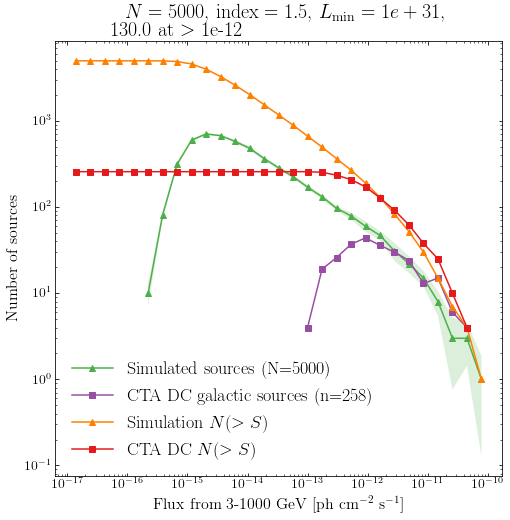

In [39]:
###Example run


lb_frac,std_lb_frac,mp,tev,std_tev = ave_samples(10,Nsnr=5000,LF_i_snr=1.5,
                            Lmin_snr=1e31,Lmax_snr=1e35,
                            plothist=True,printstatements=False,
                           alpha=alp,beta=bet,H=H,
                           hist_3fgl=hist_CTA,ft=1e-12,spectrum=spec_ave_CTA,cm=True)

    
# hist = np.histogram(ave_flux,bins=bins)[0]
# plt.figure()
# plt.loglog(bins_mean,np.cumsum(hist[::-1])[::-1],marker='s')
# plt.loglog(bins_mean,np.cumsum(hist_CTA[::-1])[::-1],marker='o')

# mp[mp==0]=1e-16

# fig = plt.figure(figsize=(25,10))
# ax = fig.add_subplot(111)
# ax.set_xticks([0,180,360,540,720])
# ax.set_xticklabels([0,90,180,270,360])
# ax.set_yticks([0,90,180,270,360])
# ax.set_yticklabels([90,45, 0,-45,-90])
# ax.set_ylim([140,220])
# ax.set_xlabel('l')
# ax.set_ylabel('b')
# im = ax.imshow(np.log10(mp[:,:]),cmap='hot',vmin=-16,vmax=-9)
# fig.colorbar(im,orientation='horizontal',shrink=0.5);


2942.14917642
Doing 10 sample galaxys with 2942.0 sources,LF_i = 1.3, Lmin = 1e+30,Lmax=2e+35, 
    this might take some time...
Simulation counts > 1e-12: 118.0
CTA DC counts > 1e-12: 128
...done
13733.4210905
Doing 10 sample galaxys with 13733.0 sources,LF_i = 1.5, Lmin = 1e+30,Lmax=2e+35, 
    this might take some time...
Simulation counts > 1e-12: 128.0
CTA DC counts > 1e-12: 128
...done
72226.2728206
Doing 10 sample galaxys with 72226.0 sources,LF_i = 1.7, Lmin = 1e+30,Lmax=2e+35, 
    this might take some time...
Simulation counts > 1e-12: 140.0
CTA DC counts > 1e-12: 128
...done
400829.327115
1.9 1e+30 2e+35
Too much sources :(
1435.87801348
Doing 10 sample galaxys with 1436.0 sources,LF_i = 1.3, Lmin = 1e+31,Lmax=2e+35, 
    this might take some time...
Simulation counts > 1e-12: 120.0
CTA DC counts > 1e-12: 128
...done
4321.84414539
Doing 10 sample galaxys with 4322.0 sources,LF_i = 1.5, Lmin = 1e+31,Lmax=2e+35, 
    this might take some time...
Simulation counts > 1e-12: 125.

/home/mart/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in multiply


...done
14399.7794666
Doing 10 sample galaxys with 14400.0 sources,LF_i = 1.7, Lmin = 1e+31,Lmax=2e+35, 
    this might take some time...
Simulation counts > 1e-12: 143.0
CTA DC counts > 1e-12: 128
...done
50455.4850553
Doing 10 sample galaxys with 50455.0 sources,LF_i = 1.9, Lmin = 1e+31,Lmax=2e+35, 
    this might take some time...
Simulation counts > 1e-12: 174.0
CTA DC counts > 1e-12: 128
...done
680.95413623
Doing 10 sample galaxys with 681.0 sources,LF_i = 1.3, Lmin = 1e+32,Lmax=2e+35, 
    this might take some time...
Simulation counts > 1e-12: 119.0
CTA DC counts > 1e-12: 128
...done
1345.64219334
Doing 10 sample galaxys with 1346.0 sources,LF_i = 1.5, Lmin = 1e+32,Lmax=2e+35, 
    this might take some time...
Simulation counts > 1e-12: 125.0
CTA DC counts > 1e-12: 128
...done
2861.87716695
Doing 10 sample galaxys with 2862.0 sources,LF_i = 1.7, Lmin = 1e+32,Lmax=2e+35, 
    this might take some time...
Simulation counts > 1e-12: 133.0
CTA DC counts > 1e-12: 128
...done
6346.03

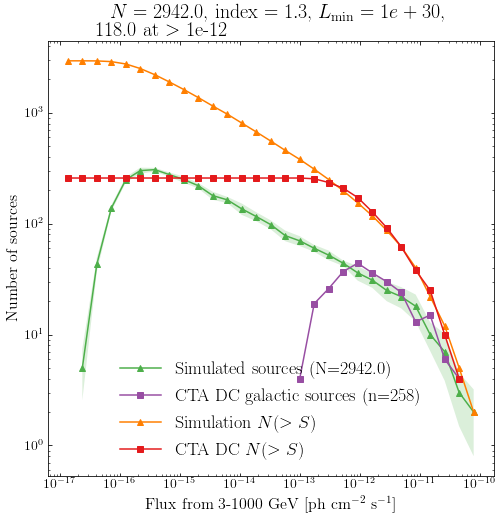

In [ ]:
###Only SNR/spp/pwn population
### Do several mock galaxies with different luminosity function/no. sources

###These options showed to reproduce the number of sources at high flux

frac_op = []
std_frac_op = []
lb_frac_TeV = []
lb_frac_TeV_std = []

L_min = [1e31,5e31,1e32]
aa = [1.2,1.5,1.8,2.1]
L_max = [2e35]


L_min = np.logspace(30,33,10)
L_max = np.logspace(34,36,10)
#L_min = [1e31]
aa = [1.3,1.5,1.7,1.9]
L_min = [1e30,1e31,1e32]
#aa = [1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]
L_max = [2e35]




options = []
Nft = 137
ft = 1e-12
Dmin = 7.5*kpc

for Lmin in L_min:
    for a in aa:
        for Lmax in L_max:
            N = Nft*(Lmin**(1-a)-Lmax**(1-a))/((4*np.pi*ft*Dmin**2)**(1-a)-Lmax**(1-a))
            print N
            N = np.rint(N)
            if N > 100000:
                print a,Lmin,Lmax
                print "Too much sources :("
                lb_frac_TeV.append(np.inf*np.zeros(len(lb)))
                continue
                
            options.append((N,a,Lmin,Lmax))
            lb_frac,std_lb_frac,mp,lb_tev,lb_tev_std = ave_samples(10,Nsnr=N,LF_i_snr=a,
                            Lmin_snr=Lmin,Lmax_snr=Lmax,
                            plothist=True,printstatements=False,
                           alpha=alp,beta=bet,H=H,
                           hist_3fgl=hist_CTA,ft=1e-12,spectrum=spec_ave_CTA,cm=False)

            frac_op.append(lb_frac)
            std_frac_op.append(std_lb_frac)
            lb_frac_TeV.append(lb_tev)
            lb_frac_TeV_std.append(lb_tev_std)

Doing 100 sample galaxys with 3700 sources,LF_i = 1.3, Lmin = 1e+30,Lmax=1e+35, 
    this might take some time...
Simulation counts > 1e-12: 129.0
CTA DC counts > 1e-12: 128
...done
Doing 100 sample galaxys with 15500 sources,LF_i = 1.5, Lmin = 1e+30,Lmax=1e+35, 
    this might take some time...
Simulation counts > 1e-12: 128.0
CTA DC counts > 1e-12: 128
...done
Doing 100 sample galaxys with 68500 sources,LF_i = 1.7, Lmin = 1e+30,Lmax=1e+35, 
    this might take some time...
Simulation counts > 1e-12: 127.0
CTA DC counts > 1e-12: 128
...done
Doing 100 sample galaxys with 1800 sources,LF_i = 1.3, Lmin = 1e+31,Lmax=1e+35, 
    this might take some time...
Simulation counts > 1e-12: 128.0
CTA DC counts > 1e-12: 128
...done
Doing 100 sample galaxys with 4800 sources,LF_i = 1.5, Lmin = 1e+31,Lmax=1e+35, 
    this might take some time...
Simulation counts > 1e-12: 126.0
CTA DC counts > 1e-12: 128
...done
Doing 100 sample galaxys with 13500 sources,LF_i = 1.7, Lmin = 1e+31,Lmax=1e+35, 
    th

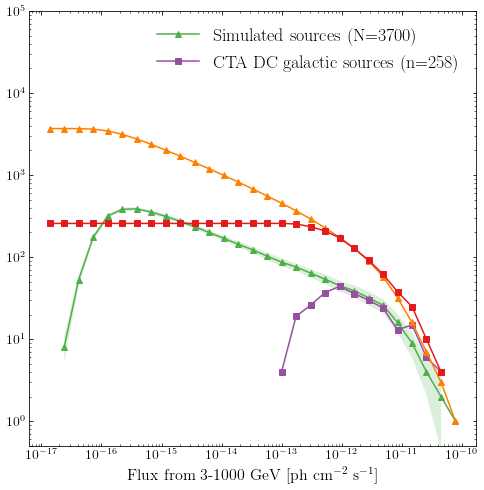

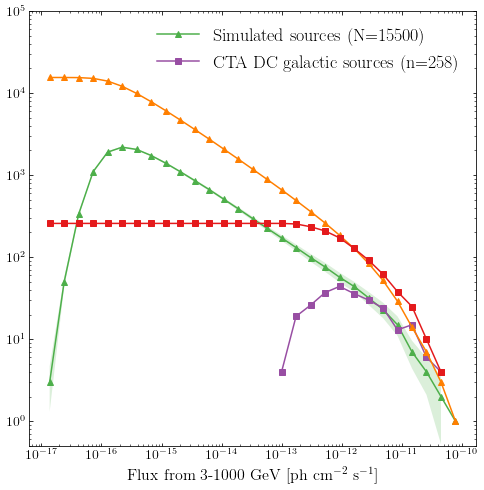

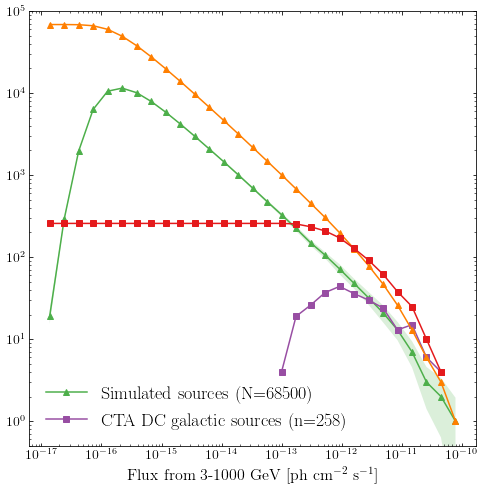

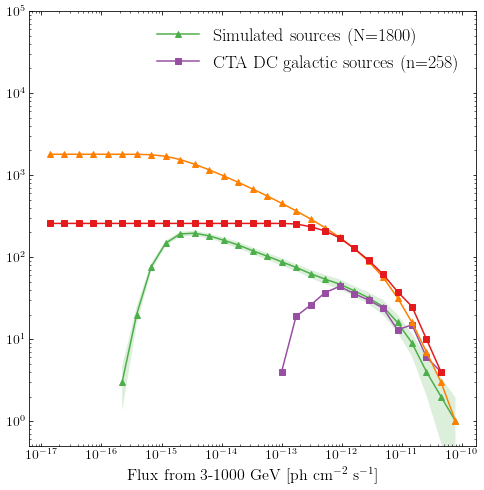

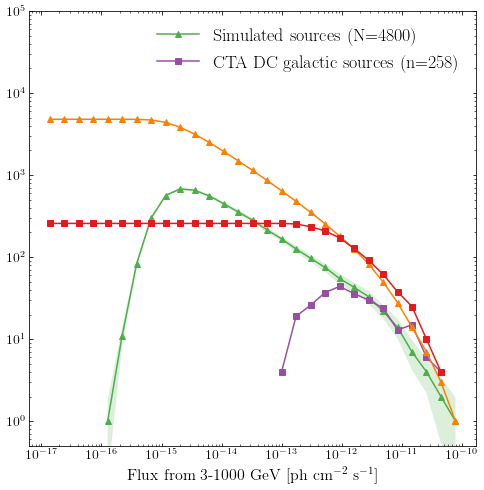

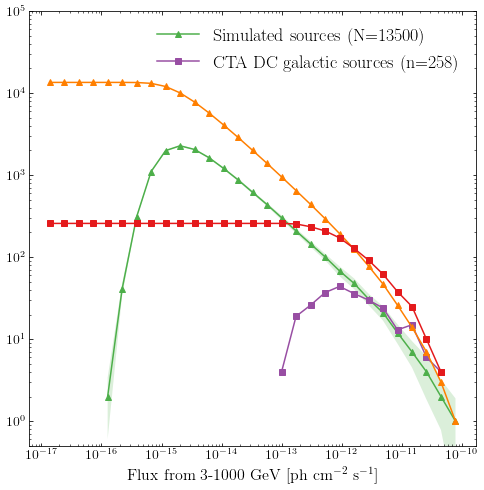

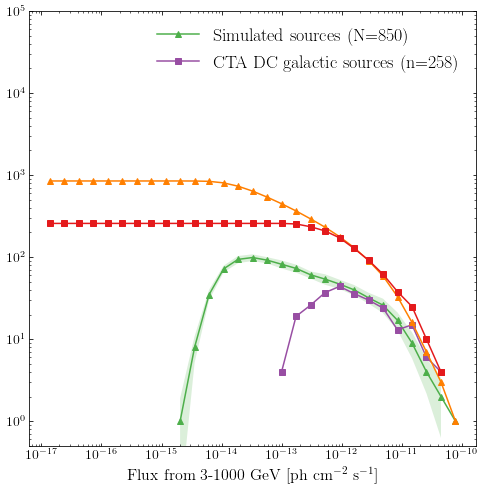

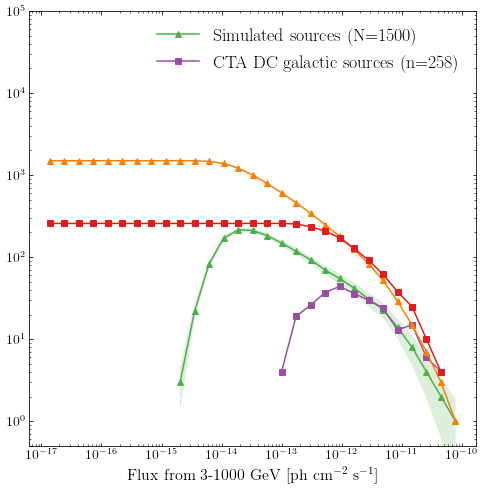

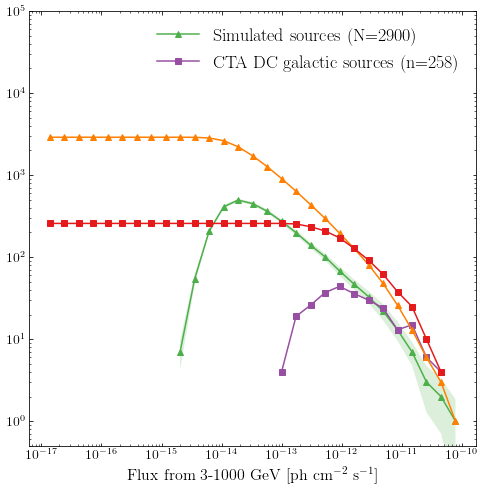

In [32]:
###Only SNR/spp/pwn population
### Do several mock galaxies with different luminosity function/no. sources

###These options showed to reproduce the number of sources at high flux

frac_op = []
std_frac_op = []
lb_frac_TeV = []
lb_frac_TeV_std = []



# options = [(1900,1.2,1e30),(3700,1.3,1e30),(7300,1.4,1e30),(15500,1.5,1e30),(33000,1.6,1e30),
#           (68000,1.7,1e30),(1200,1.2,1e31),(3000,1.4,1e31),(2800,1.4,1e31),(4800,1.5,1e31),
#           (8400,1.6,1e31),(13500,1.7,1e31),(620,1.2,1e32),(850,1.3,1e32),(1100,1.4,1e32),(1500,1.5,1e32),
#           (2100,1.6,1e32),(2900,1.7,1e32)]

options = [(3700,1.3,1e30),(15500,1.5,1e30),(68500,1.7,1e30),(1800,1.3,1e31),(4800,1.5,1e31),
          (13500,1.7,1e31),(850,1.3,1e32),(1500,1.5,1e32),(2900,1.7,1e32)]

Lmax = 1e35
for op in options:
    N,a,Lmin = op

    lb_frac,std_lb_frac,mp,lb_tev,lb_tev_std = ave_samples(100,Nsnr=N,LF_i_snr=a,
                    Lmin_snr=Lmin,Lmax_snr=Lmax,
                    plothist=True,printstatements=False,
                   alpha=alp,beta=bet,H=H,
                   hist_3fgl=hist_CTA,ft=1e-12,spectrum=spec_ave_CTA,cm=False)

    frac_op.append(lb_frac)
    std_frac_op.append(std_lb_frac)
    lb_frac_TeV.append(lb_tev)
    lb_frac_TeV_std.append(lb_tev_std)

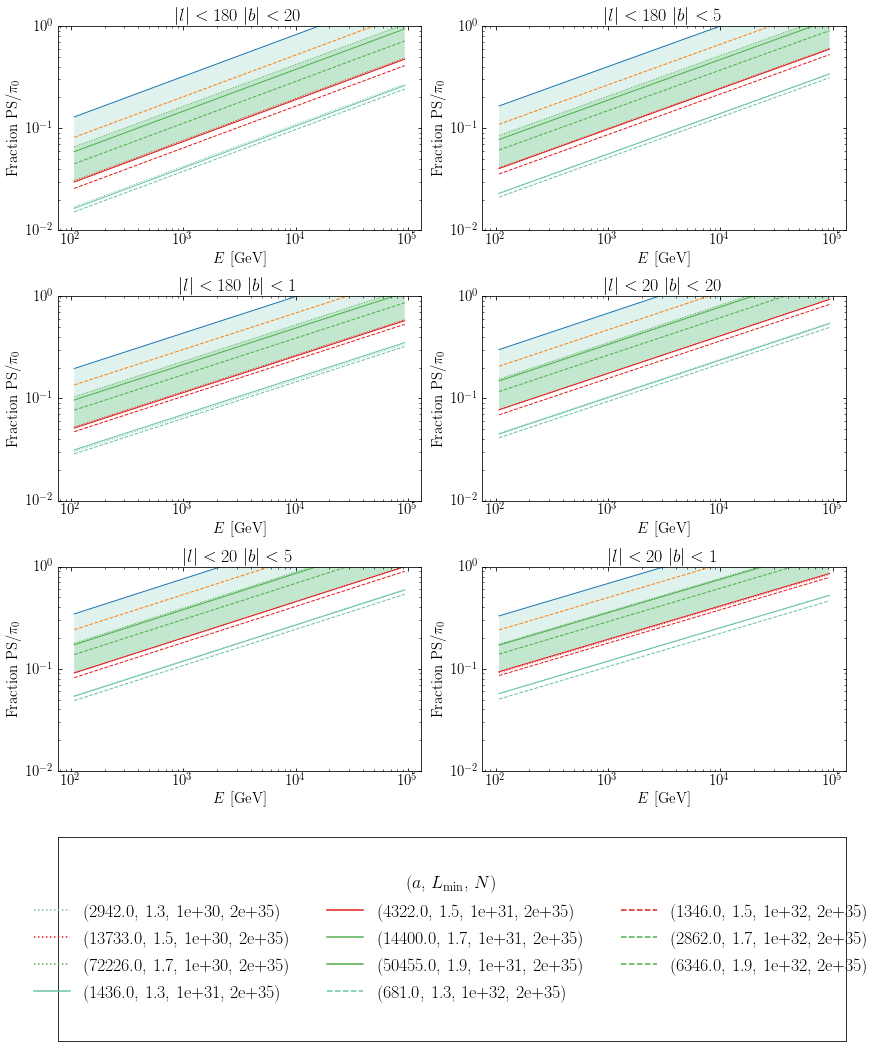

In [60]:
###Plot the fraction of unresolved/diffuse at different l,b
frac_op = np.array(frac_op)
std_frac_op = np.array(std_frac_op)

fig = plt.figure(figsize=(12,16))
gs = gridspec.GridSpec(4,2)

for di in range(len(lb)):
    #print "At abs(l,b):",lb[di]
    gsi = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec=gs[di])
    ax = plt.Subplot(fig,gs[di]) 
    for i,sf in enumerate(frac_op[:,di]):
        if options[i][1]==1.3:
            #_ls = '-'
            color = colors[0]
        elif options[i][1]==1.5:
            #_ls = '--'
            color = colors[5]
        elif options[i][1]==1.7:
            #_ls = '-.'
            color = colors[2]
        else:
             color= ax._get_lines.prop_cycler.next()['color']
            
        if options[i][2]==1e30:
            #color = colors[5] #red
            _ls = ':'
        elif options[i][2]==1e31:
            #color = colors[0] #blue
            _ls = '-'
        elif options[i][2]== 1e32:
            #color= colors[2] #green
            _ls = '--'
        else:
            _ls = "-"
        if options[i][1]==1.8 and options[i][2]==2e34:
            thick = 2
        else:
            thick = 1
        #print options_print[i]
        div = frac_op[i,di]
        ax.loglog(E,div,label=options[i],ls=_ls,color=color,lw=thick)#marker=_ms,ms=1)
        
        #ax.fill_between(E,div-std_frac_op[i,di],div+std_frac_op[i,di],alpha=0.2)#,facecolor=colors[i])
        ax.set_xscale('log',nonposx='clip')
        ax.set_yscale('log',nonposy='clip')
        #print "At %.1f GeV the fraction is %.2f "%(E[iE100],div[iE100])
    ax.fill_between(E,frac_op[2,di],frac_op[4,di],alpha=0.2,facecolor=colors[2])
    ax.fill_between(E,frac_op[6,di],frac_op[4,di],alpha=0.2,facecolor=colors[0])
    ax.set_ylim([0.01,1])
    ax.set_title(r'$|l| < %s \ |b| < %s$'%lb[di],fontsize=18)
    ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=15)
    ax.set_xlabel(r"$E$ [GeV]",fontsize=15)
    ax.set_ylabel(r'Fraction $\rm PS/ \pi_0$',fontsize=15)
    fig.add_subplot(ax)
    #plt.legend(loc=2,frameon=False,fontsize=15,ncol=2)#, title=options_labels[0:4])
##Plot legend in seperate subplot
plt.gca().set_prop_cycle(None)
gsi = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=gs[di+1])

ax = plt.subplot(gs[-1,:]) 

ax.set_frame_on(True)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for i,sf in enumerate(frac_op[:,di]):      
    div = frac_op[i,di]
    if options[i][1]==1.3:
        #_ls = '-'
        color = colors[0]
    elif options[i][1]==1.5:
        #_ls = '--'
        color = colors[5]
    elif options[i][1]==1.7:
        #_ls = '-.'
        color = colors[2]
#     else:
#         color= ax._get_lines.prop_cycler.next()['color']

    if options[i][2]==1e30:
        #color = colors[5] #red
        _ls = ':'
    elif options[i][2]==1e31:
        #color = colors[0] #blue
        _ls = '-'
    elif options[i][2]== 1e32:
        #color= colors[2] #green
        _ls = '--'
    else:
        _ls = "-"
    if options[i][0]==1.8 and options[i][1]==2e34:
        thick = 2
    else:
        thick = 1
    ax.plot(0,0,label=options[i],ls=_ls,color=color)
    
fig.add_subplot(ax)
lg = plt.legend(loc=10,title=r'($a$, $L_{\rm min}$, $N$)',frameon=False,ncol=3,fontsize=18)
lg.get_title().set_fontsize(18)
#fig2.suptitle(r'PS index = %s, diffuse index = 2.52-2.61'%(snr_index),fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('fraction_ps_diffuse.pdf')

## Flux at 1 TeV

In [13]:
lb_frac_TeV = np.array(lb_frac_TeV)
lb_frac_TeV_std = np.array(lb_frac_TeV_std)
x = np.array(aa) #L_min

y = L_min
X,Y = np.meshgrid(x,y)

lb_frac_TeV_0 = lb_frac_TeV[:,0]
Z = lb_frac_TeV_0.reshape(X.shape,order='C')
#X = np.log10(X)
Y = np.log10(Y)

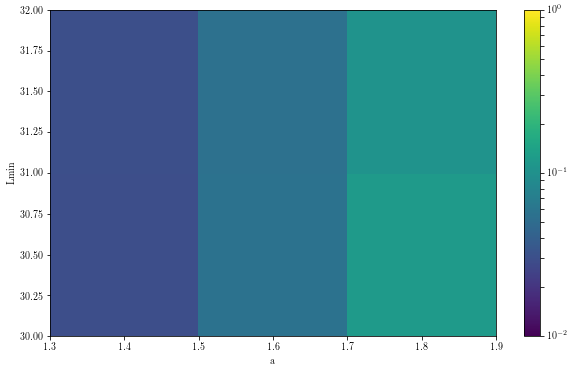

In [16]:
from matplotlib.colors import LogNorm

Z = np.ma.masked_where(np.isnan(Z), Z)
cmap = plt.cm.viridis
cmap.set_bad('white')
plt.pcolor(X,Y,Z,norm=LogNorm(vmin=0.01, vmax=1),cmap=cmap,vmin = 0.01,vmax=1)
plt.xlabel("a")
plt.ylabel("Lmin")
plt.colorbar()